In [23]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import numpy as np

from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from art.attacks import ProjectedGradientDescent as attack
from art.classifiers import PyTorchClassifier
from art.utils import load_mnist
import pdb
import spams as sp

from adversarial_sparse_toolbox import *

In [10]:
# parameters
n = 100
m = 120
k = 15
N = 100
lambd = .2
margin = .05

model = SSC_Model_separable(n,m,k,N,lambd,margin)


(x,y) = (model.x, model.labels)
N_ = len(y)
y_expanded = torch.cat( ( ( y>0 ).view(N_,1) , ( y<0 ).view(N_,1) ), dim=1 )
min_pixel_value = torch.min(x)
max_pixel_value = torch.max(x)


The emperical mu is 0.05426, while the theoretical bound is 0.04100.
Margin verified and satisfied.


In [11]:

criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.01)
classifier = PyTorchClassifier(
    model=model,
    clip_values=(min_pixel_value, max_pixel_value),
    loss=criterion,
    optimizer='',
    input_shape=(1,1,n),
    nb_classes=2,
    device_type='cpu'
)

Maximum sparsity: 19
Optimal s = 16; Bounds: B1 = 0.0376, B2 = 0.0216


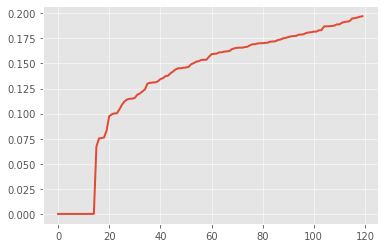

In [12]:
Max_S = int(np.floor(1/model.mu + 1))
print('Maximum sparsity: %d'%(Max_S))

tests = np.zeros(Max_S)
for i in range(Max_S):
    s = i
    gap,projs = get_encoderGap(model,x,s)
    B1 = gap / 2
    B2 = margin * torch.sqrt(1-model.mu * (s-1))
    tests[i] = min(B1,B2)

s = np.argmax(tests)+1
gap,projs = get_encoderGap(model,x,s)
plt.style.use('ggplot')
plt.plot(projs.numpy())
B1 = gap / 2
B2 = margin * np.sqrt(1-model.mu.cpu().numpy() * (s-1))
Bound = min(B1,B2)
print('Optimal s = %d; Bounds: B1 = %.4f, B2 = %.4f'%(s,B1,B2))
# print('Previous Bound (Romano et al) = %.4f'%(bound_old))


In [13]:
mus = get_babel(model)
Max_S = torch.sum(mus<1)
print('Maximum sparsity: %d'%(Max_S))

tests = np.zeros(Max_S)
for i in range(Max_S):
    s = i
    gap,projs = get_encoderGap(model,x,s)
    B1 = gap / 2
    B2 = margin * torch.sqrt(1-(mus[s-1]-mus[0]))
    tests[i] = min(B1,B2)

s = np.argmax(tests)+1
gap,projs = get_encoderGap(model,x,s)
B1 = gap / 2
B2 = margin * torch.sqrt(1-mus[s-1]).numpy()
Bound = min(B1,B2)
print('Optimal s = %d; Bounds: B1 = %.4f, B2 = %.4f'%(s,B1,B2))
# print('Previous Bound (Romano et al) = %.4f'%(bound_old))


Maximum sparsity: 19
Optimal s = 16; Bounds: B1 = 0.0376, B2 = 0.0203


In [14]:
# Step 5: Evaluate the ART classifier on benign test examples
predictions = classifier.predict(x)
Acc_0 = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_expanded.numpy(), axis=1)) / len(y)
print("Accuracy on benign test examples: {}%".format(Acc_0 * 100))

Accuracy on benign test examples: 100.0%


In [ ]:
# Step 6: Generate adversarial test examples
AdvEnery = np.logspace(np.log10(.006),np.log10(1),20)
Acc = np.zeros(len(AdvEnery))

for i in range(len(AdvEnery)):
    adversary = attack(classifier=classifier, eps=AdvEnery[i], norm=2, eps_step=AdvEnery[i]/3,max_iter=25)
    x_test_adv = adversary.generate(x=x)
    predictions = classifier.predict(x_test_adv)
    Acc[i] = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_expanded.numpy(), axis=1)) / len(y_expanded)
    

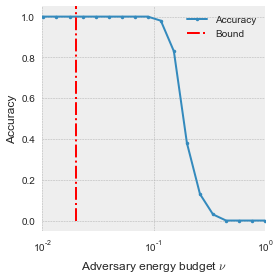

In [76]:
# Plotting
plt.style.use('bmh')
plt.figure(figsize=(4,4))
plt.semilogx(AdvEnery,Acc,'.-',label = 'Accuracy')
# plt.semilogx(AdvEnery,Acc_0*np.ones(AdvEnery.shape),'g-.',label='Benign Accuracy')
plt.plot([Bound,Bound],[np.min(Acc)*.8,np.max(Acc)*1.05],'-.r',label='Bound')
plt.xlabel(r'Adversary energy budget $\nu$')
plt.ylabel('Accuracy')
plt.ylim([-.05,1.05])
plt.xlim([0.01,1])
plt.legend(loc='best')
plt.tight_layout()
plt.axis('on')
plt.savefig('synthetic_demo_sep_trans.pdf',transparent = True, dpi = 100)
plt.show()